In [1]:
import copy
import json
import numpy as np
import torch
import torch.nn.utils.prune as prune
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from inspect_weights import load_weights
from vib_lenet_300_100_mnist import (
    VIBLeNet, MnistCsvDataset, train_test_split,
    batch_size, z_dim, evaluate
)
from testing_utils import get_device
from msc.plotting import plot_x_y
#%matplotlib widget

torch.manual_seed(42)
device = get_device()
print(f"using device: {device}")

using device: cpu
using device: cpu


In [2]:
model = VIBLeNet(z_dim=z_dim).to(device)
weights = load_weights(f"../weights/vib_lenet_300_100_mnist.pth", verbose=False)
model.load_state_dict(weights)

<All keys matched successfully>

In [19]:
1

In [20]:
dataset = MnistCsvDataset("../data/mnist_data.csv")
train_size = int(train_test_split * len(dataset))
test_size = len(dataset) - train_size
print(f'train_size: {train_size}, test_size: {test_size}')

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

betas = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]

train_size: 56000, test_size: 14000


In [21]:
og_acc_list = []
pruned_acc_list = []
og_kll = []
pruned_kll = []


for b in tqdm(betas):
    pruned_model = copy.deepcopy(model)
    pruned_model, effective_z, kl_scores = vib_prune_by_kl_contribution(
        pruned_model, train_loader, device, keep_ratio=0.5, beta=b
    )

    _, pruned_test_acc, pruned_kl, _ = evaluate(pruned_model, test_loader, device, beta=b)
    _, og_test_acc, og_kl, _ = evaluate(model, test_loader, device, beta=b)
    
    og_acc_list.append(og_test_acc)
    pruned_acc_list.append(pruned_test_acc)
    og_kll.append(og_kl)
    pruned_kll.append(pruned_kl)

  0%|                                                                                                                                                                                                                                                      | 0/9 [00:00<?, ?it/s]

   PRUNED: 10 → 5 dims (kept HIGH KL)
   Top KL kept: 0.4289 | Bottom pruned: 0.2371


 11%|██████████████████████████▍                                                                                                                                                                                                                   | 1/9 [00:01<00:09,  1.23s/it]

   PRUNED: 10 → 5 dims (kept HIGH KL)
   Top KL kept: 0.4288 | Bottom pruned: 0.2371


 22%|████████████████████████████████████████████████████▉                                                                                                                                                                                         | 2/9 [00:02<00:06,  1.04it/s]

   PRUNED: 10 → 5 dims (kept HIGH KL)
   Top KL kept: 0.4288 | Bottom pruned: 0.2371


 33%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 3/9 [00:02<00:04,  1.26it/s]

   PRUNED: 10 → 5 dims (kept HIGH KL)
   Top KL kept: 0.4289 | Bottom pruned: 0.2371


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 4/9 [00:03<00:03,  1.29it/s]

   PRUNED: 10 → 5 dims (kept HIGH KL)
   Top KL kept: 0.4288 | Bottom pruned: 0.2371


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 6/9 [00:04<00:02,  1.43it/s]

   PRUNED: 10 → 5 dims (kept HIGH KL)
   Top KL kept: 0.4288 | Bottom pruned: 0.2371
   PRUNED: 10 → 5 dims (kept HIGH KL)
   Top KL kept: 0.4288 | Bottom pruned: 0.2371


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 7/9 [00:05<00:01,  1.41it/s]

   PRUNED: 10 → 5 dims (kept HIGH KL)
   Top KL kept: 0.4288 | Bottom pruned: 0.2371


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8/9 [00:05<00:00,  1.49it/s]

   PRUNED: 10 → 5 dims (kept HIGH KL)
   Top KL kept: 0.4289 | Bottom pruned: 0.2371


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.37it/s]


In [22]:
for og, pruned, og_kl, pruned_kl in zip(og_acc_list, pruned_acc_list, og_kll, pruned_kll):
    print(f'diff: {pruned-og:.3f} -> og: {og:.3f}, pruned: {pruned:.3f}, og_kl: {og_kl}, pruned_kl: {pruned_kl}')

diff: -19.436 -> og: 93.521, pruned: 74.086, og_kl: 3.330698013305664, pruned_kl: 24.665124893188477
diff: -18.764 -> og: 93.114, pruned: 74.350, og_kl: 3.3306992053985596, pruned_kl: 24.66513442993164
diff: -20.057 -> og: 93.700, pruned: 73.643, og_kl: 3.3306987285614014, pruned_kl: 24.665128707885742
diff: -19.407 -> og: 93.900, pruned: 74.493, og_kl: 3.3306984901428223, pruned_kl: 24.665132522583008
diff: -18.807 -> og: 93.414, pruned: 74.607, og_kl: 3.3306992053985596, pruned_kl: 24.66513442993164
diff: -19.021 -> og: 93.243, pruned: 74.221, og_kl: 3.3306996822357178, pruned_kl: 24.665132522583008
diff: -19.543 -> og: 93.686, pruned: 74.143, og_kl: 3.3306992053985596, pruned_kl: 24.665128707885742
diff: -19.479 -> og: 93.479, pruned: 74.000, og_kl: 3.3306989669799805, pruned_kl: 24.665128707885742
diff: -19.843 -> og: 93.721, pruned: 73.879, og_kl: 3.3306987285614014, pruned_kl: 24.66512680053711


/tmp/ipykernel_1055405/3224772291.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


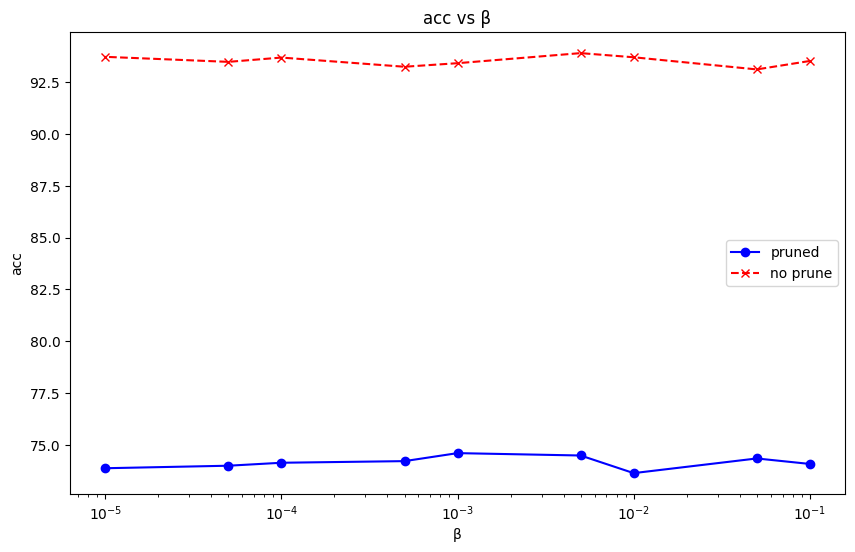